# Cloud masking with Sentinel Hub and s2cloudless

Notebook showing how to get cloud masks from [Sentinel Hub services](https://medium.com/sentinel-hub/cloud-masks-at-your-service-6e5b2cb2ce8a), or compute them locally using `mask.eotask_cloud_mask` module.

In [12]:
%matplotlib inline

import datetime as datetime
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import BBox, CRS, DataCollection

from eolearn.core import FeatureType, LinearWorkflow
from eolearn.io import SentinelHubInputTask
from eolearn.mask import CloudMaskTask

Define ROI BBOX and time interval, in this case a bounding box around Ljubljana, February - April 2020

In [13]:
roi_bbox = BBox([14.218369, 46.007455, 14.71344, 46.271275], crs=CRS.WGS84)

time_interval = ('2020-02-01', '2020-05-01')

### Use Sentinel Hub precomputed cloud masks and cloud probabilities

This task will download RGB Sentinel-2 bands together with CLM and CLP bands. See [blog](https://medium.com/sentinel-hub/cloud-masks-at-your-service-6e5b2cb2ce8a) on cloud masks available on Sentinel Hub. 

The downloaded masks will be stored in 
  * `CLM` - cloud mask
  * `CLP` - cloud pseudo-probabilities

In [14]:
input_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=['B02','B03','B04'],
    bands_feature=(FeatureType.DATA, 'trueColorBands'),
    additional_data=[(FeatureType.MASK, 'dataMask'), (FeatureType.MASK, 'CLM'), (FeatureType.DATA, 'CLP')],
    resolution=(160, 160),
    time_difference=datetime.timedelta(hours=2),
    max_threads=3
)

In [15]:
%%time
eopatch = input_task.execute(bbox=roi_bbox, time_interval=time_interval)

CPU times: user 527 ms, sys: 96.4 ms, total: 623 ms
Wall time: 5.29 s


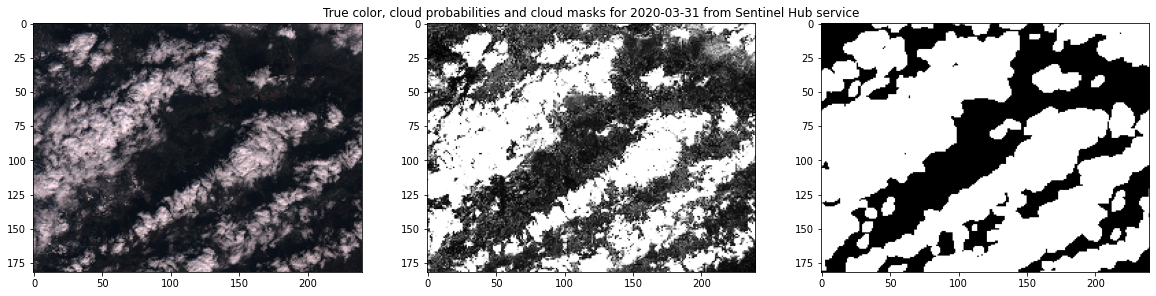

In [16]:
timestamp_idx = 11

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
ax[0].imshow(eopatch.data['trueColorBands'][timestamp_idx][...,[2,1,0]])
ax[1].imshow(np.squeeze(eopatch.data['CLP'][timestamp_idx]), cmap='gray')
ax[2].imshow(np.squeeze(eopatch.mask['CLM'][timestamp_idx]), cmap='gray')

ax[1].set_title(f'True color, cloud probabilities and cloud masks for {eopatch.timestamp[timestamp_idx].date().isoformat()} from Sentinel Hub service');

### Compute cloud maps yourself

In this workflow example, the cloud maps are computed locally by requesting appropriate bands from service and running [S2Cloudless](https://github.com/sentinel-hub/sentinel2-cloud-detector).  

In [17]:
bands_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=['B01','B02','B04','B05','B08','B8A','B09','B10','B11','B12'],
    bands_feature=(FeatureType.DATA, 'bands'),
    additional_data=[(FeatureType.MASK, 'dataMask')],
    resolution=(160, 160),
    time_difference=datetime.timedelta(hours=2),
    max_threads=3
)

add_clm = CloudMaskTask(data_feature='bands', all_bands=False, is_data_feature='dataMask', 
                        mono_features=('CLP', 'CLM'), mask_feature=None, processing_resolution='160m')

Run the whole workflow: download bands and execute `CloudMaskTask`:

In [18]:
%%time
workflow = LinearWorkflow((bands_task, 'add data'), (add_clm, 'compute cloud mask'))
result = workflow.execute({bands_task: {'bbox': roi_bbox, 'time_interval': time_interval}})
eopatch_clm = result[add_clm]

CPU times: user 51.6 s, sys: 387 ms, total: 52 s
Wall time: 11.6 s


Plot results

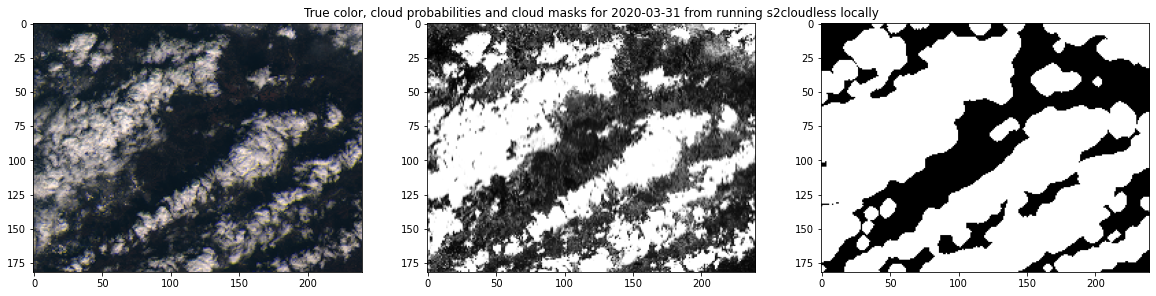

In [19]:
timestamp_idx = 11

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
ax[0].imshow(eopatch_clm.data['bands'][timestamp_idx][...,[2,1,0]])
ax[1].imshow(np.squeeze(eopatch_clm.data['CLP'][timestamp_idx]), cmap='gray')
ax[2].imshow(np.squeeze(eopatch_clm.mask['CLM'][timestamp_idx]), cmap='gray')

ax[1].set_title(f'True color, cloud probabilities and cloud masks for {eopatch.timestamp[timestamp_idx].date().isoformat()} from running s2cloudless locally');

### Multi-temporal cloud masks

The `CloudMaskTask` also supports multi-temporal cloud masking, taking several observations into account when calculating masks for any given observation. As we have already all the data available, we'll just create the task and execute it on the `eopatch_clm`. For possible comparison with mono-temporal masks, we'll append the multi-temporal cloud masks and pseudoprobabilities with `_multi`. 

In [20]:
add_multitemporal_clm = CloudMaskTask(data_feature='bands', all_bands=False, is_data_feature='dataMask', 
                                      multi_features=('CLP_multi', 'CLM_multi'), mask_feature=None, processing_resolution='160m')

In [21]:
%%time
eopatch_multi = add_multitemporal_clm.execute(eopatch_clm)

CPU times: user 2min 31s, sys: 3.44 s, total: 2min 34s
Wall time: 14 s


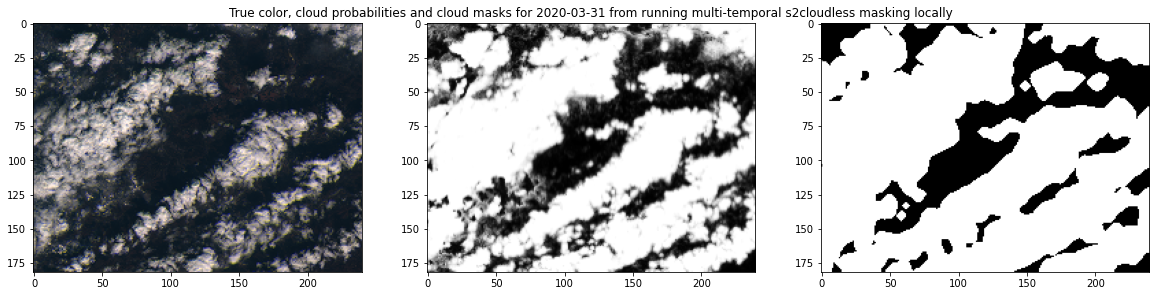

In [22]:
timestamp_idx = 11

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
ax[0].imshow(eopatch_clm.data['bands'][timestamp_idx][...,[2,1,0]])
ax[1].imshow(np.squeeze(eopatch_clm.data['CLP_multi'][timestamp_idx]), cmap='gray')
ax[2].imshow(np.squeeze(eopatch_clm.mask['CLM_multi'][timestamp_idx]), cmap='gray')

ax[1].set_title(f'True color, cloud probabilities and cloud masks for {eopatch.timestamp[timestamp_idx].date().isoformat()} from running multi-temporal s2cloudless masking locally');

### Before you go

Using cloud masks provided by the service suffices for most use cases, driving down the cost of your processing while being faster. You might have noticed the `%%time` magic command used throughout the notebook; in my case, the comparison of the three approaches shows:
 * Sentinel Hub services:   
     `CPU times: user 527 ms, sys: 96.4 ms, total: 623 ms`
 * mono-temporal cloud mask   
     `CPU times: user 51.6 s, sys: 387 ms, total: 52 s`
 * multi-temporal cloud masking   
     `CPU times: user 2min 31s, sys: 3.44 s, total: 2min 34s`

Unless Sentinel Hub provided cloud masks are not sufficient in your use case, we strongly incourage you to use them. Please see the [blog post](https://medium.com/sentinel-hub/cloud-masks-at-your-service-6e5b2cb2ce8a) for details.
